# NLP Guide

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="`np.bool8` is a deprecated alias for `np.bool_`.")
warnings.filterwarnings("ignore", category=DeprecationWarning, message="`np.bool8` is a deprecated alias")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="bokeh")

import logging
logging.getLogger('gensim').setLevel(logging.ERROR)

import requests
from bs4 import BeautifulSoup
from lxml import html
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import corpora
from gensim import models
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel
from collections import Counter
from pprint import pprint
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer
import lda

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

In [6]:
# Dataset Generation

d1 = pd.read_excel('KeyBrutality-Oct2012.xlsx')
d2 = pd.read_excel('KeyBrutality-May2017.xlsx')
d3 = pd.concat([d1, d2]).reset_index(drop = True)
d3 = d3[d3['URL'].notnull()]
d3.head()

,URL,Decision Date,Case Number,Personal Ruling,Notes,Brutality Ruling,Brutality Word Count,Police Word Count,Brutality Citation Count,Brutality Instances,Police Instances,Brutality in Citation Sentence,Amendment Word Count,Summary Brutality Word Count,Summary Police Word Count
0,https://www.leagle.com/decision/infco20200902106,"Argued and Submitted October 18, 2012.",No. 09-73088.,,,0.0,0.0,0.0,0.0,[],[],[],0.0,0.0,0.0
1,https://www.leagle.com/decision/infco20150514111,"Argued October 11, 2012.","Nos. 06-50677, 07-50037, 06-50678, 06-50679.",,,0.0,0.0,74.0,0.0,[],"[""We issued an unpublished memorandum disposit...",[],0.0,0.0,1.0
2,https://www.leagle.com/decision/infco20130109084,"Argued: October 24, 2012.",No. 11-2078.,,,0.0,0.0,0.0,0.0,[],[],[],0.0,0.0,0.0
3,https://www.leagle.com/decision/infco20150318140,"Argued and Submitted October 3, 2012.","Nos. 11-35914, 11-35931.",,,0.0,0.0,6.0,0.0,[],['Metro\'s general manager concurred in the p...,[],0.0,0.0,0.0
4,https://www.leagle.com/decision/infco20150226129,"Argued: October 3, 2012.",Docket No. 11-2610-cv.,,,0.0,0.0,28.0,0.0,[],['She described her attacker to a police detec...,[],14.0,0.0,3.0


# Word2Vec

In [15]:
def text_processing(cases):
    
    # List of processed cases
    processed_cases = []

    #Remove non alphabetical characters and tokenization
    for i in tqdm(range(len(cases))):
        processed_case = cases[i].lower()
        processed_case = re.sub('[^a-zA-Z]', ' ', processed_case )
        processed_case = re.sub(r'\s+', ' ', processed_case)

        all_tags = []
        all_sentences = nltk.sent_tokenize(processed_case) # List of sentences

        #Generation of the tags
        for sent in all_sentences:
            tokens = nltk.word_tokenize(sent)
            tags = nltk.pos_tag(tokens)
            all_tags += tags

        #Lemmatization
        lemmatizer = WordNetLemmatizer()

        tags_2 = []
        for i in range(len(all_tags)):
            try:
                if all_tags[i][1] == 'ADV':
                    tag = 'r'
                else:
                    tag = all_tags[i][1][0].lower()
                tags_2.append(lemmatizer.lemmatize(all_tags[i][0], pos = tag))
            except:
                tags_2.append(all_tags[i][0])

        #Remove too short words and stopwords
        all_words = [tags_2[i] for i in range(len(tags_2)) if len(tags_2[i]) > 2 and tags_2[i] not in stopwords.words('english')]
        processed_cases.append(all_words)
    return processed_cases

In [8]:
#Extraction of a random text
index = np.random.choice(np.arange(len(d3['URL'])))
url = d3.loc[index, 'URL']
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
case = soup.find("div", class_ = 'decision-text-content')
case_text = case.get_text()
case_text[:1000]

'\n\n\nUnited States Court of Appeals, Federal Circuit.\n\n\n\n\n\n\nThis disposition is nonprecedential.\nJUDGMENT\nPER CURIAM.\nTHIS CAUSE having been heard and considered, it is\nORDERED and ADJUDGED:\nAFFIRMED.\xa0See\xa0Fed. Cir. R. 36.\n\n\nFootNotes \n1. Honorable Wiley Daniel, Chief Judge, United States District Court for the District of Colorado, sitting by designation.\n\n\n\n\n\n\n\n\n\n\n\nComment\n\n\n\nYour Name\n\n\n\nYour Email\n\n\n\nComments\n\n1000 Characters Remaining\n\n\n\n\nLeagle.com reserves the right to edit or remove comments but is under no obligation to do so, or to explain individual moderation decisions. \n\nUser Comments\n\n\n\n\n\n\n\n\n\nReply | Flag as Offensive\n\n\n\n\n\n'

In [9]:
# Preprocessing of the text

processed_case = case_text.lower()
processed_case = re.sub('[^a-zA-Z]', ' ', processed_case )
processed_case = re.sub(r'\s+', ' ', processed_case)

all_tags = []
all_sentences = nltk.sent_tokenize(processed_case) # List of sentences

for sent in all_sentences:
    tokens = nltk.word_tokenize(sent)
    tags = nltk.pos_tag(tokens)
    all_tags += tags
    
lemmatizer = WordNetLemmatizer()

tags_2 = []
for i in range(len(all_tags)):
    try:
        if all_tags[i][1] == 'ADV':
            tag = 'r'
        else:
            tag = all_tags[i][1][0].lower()
        tags_2.append(lemmatizer.lemmatize(all_tags[i][0], pos = tag))
    except:
        tags_2.append(all_tags[i][0])

all_words = [tags_2[i] for i in range(len(tags_2)) if len(tags_2[i]) > 2 and tags_2[i] not in stopwords.words('english')]

print(all_words[:100])

['united', 'state', 'court', 'appeal', 'federal', 'circuit', 'disposition', 'nonprecedential', 'judgment', 'per', 'curiam', 'cause', 'hear', 'consider', 'order', 'adjudge', 'affirm', 'see', 'fed', 'cir', 'footnote', 'honorable', 'wiley', 'daniel', 'chief', 'judge', 'united', 'state', 'district', 'court', 'district', 'colorado', 'sit', 'designation', 'comment', 'name', 'email', 'comment', 'character', 'remain', 'leagle', 'com', 'reserve', 'right', 'edit', 'remove', 'comment', 'obligation', 'explain', 'individual', 'moderation', 'decision', 'user', 'comment', 'reply', 'flag', 'offensive']


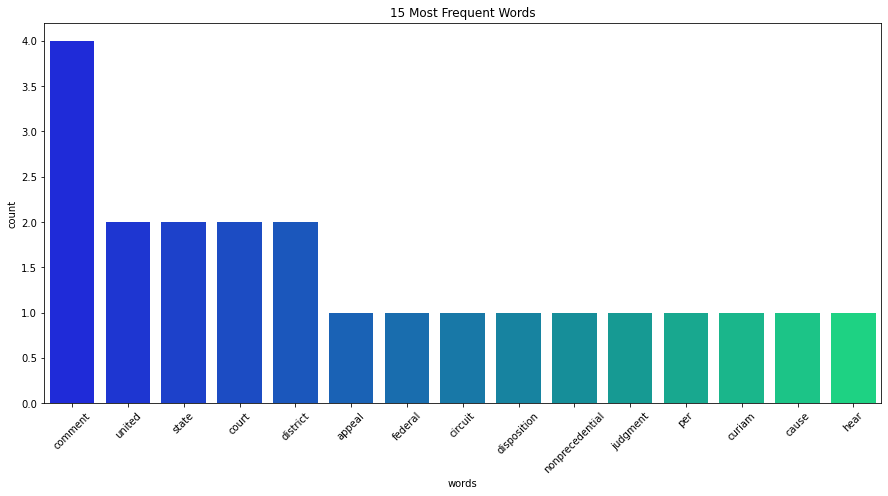

In [10]:
Counter = Counter(all_words)
most_frequent = Counter.most_common(15)

# Bar plot of frequent words
fig = plt.figure(1, figsize = (15,7))
_ = pd.DataFrame(most_frequent, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = _, palette = 'winter')
plt.xticks(rotation=45)
plt.title('15 Most Frequent Words')
plt.show()

In [139]:
# Word2Vec Model

model = Word2Vec([all_words], min_count=1)
vocab_len = len(model.wv)
print(vocab_len)
print(model.wv.get_vecattr("offensive", "count"))

462
1


In [140]:
# Word2Vec Functions

word = 'offensive'
print(model.wv.most_similar(word)[:5])  # 👍
print(model.wv.most_similar_cosmul(word)[:5])  # 👍
print(model.wv.similar_by_word(word)[:5])  # 👍
print(model.wv.similar_by_vector(word)[:5])  # 👍

# model.wv.wmdistance(wordlistA, wordlistB)  # 👍
# model.wv.doesnt_match(wordlist)  # 👍
# model.wv.similarity(wordA, wordB)  # 👍
# model.wv.n_similarity(wordlistA, wordlistB)  # 👍
# model.wv.evaluate_word_pairs(wordpairs)  # 👍
# model.wv.evaluate_word_analogies(questions)  # 👍
# model.wv.log_accuracy(section)  # 👍

[('enumerated', 0.26348012685775757), ('ask', 0.2497936338186264), ('trial', 0.24623869359493256), ('join', 0.2406400740146637), ('fall', 0.23452188074588776)]
[('enumerated', 0.6317394971847534), ('ask', 0.624896228313446), ('trial', 0.6231187582015991), ('join', 0.6203194260597229), ('fall', 0.6172603368759155)]
[('enumerated', 0.26348012685775757), ('ask', 0.2497936338186264), ('trial', 0.24623869359493256), ('join', 0.2406400740146637), ('fall', 0.23452188074588776)]
[('enumerated', 0.26348012685775757), ('ask', 0.2497936338186264), ('trial', 0.24623869359493256), ('join', 0.2406400740146637), ('fall', 0.23452188074588776)]


In [141]:
word = 'persecution'
print(model.wv.most_similar(word)[:5])  # 👍
print(model.wv.most_similar_cosmul(word)[:5])  # 👍
print(model.wv.similar_by_word(word)[:5])  # 👍
print(model.wv.similar_by_vector(word)[:5])  # 👍

[('first', 0.2906637489795685), ('although', 0.2763912081718445), ('threaten', 0.26116862893104553), ('naturalization', 0.254010409116745), ('clearly', 0.23432913422584534)]
[('first', 0.6453312635421753), ('although', 0.6381950378417969), ('threaten', 0.6305837035179138), ('naturalization', 0.6270046234130859), ('clearly', 0.6171639561653137)]
[('first', 0.2906637489795685), ('although', 0.2763912081718445), ('threaten', 0.26116862893104553), ('naturalization', 0.254010409116745), ('clearly', 0.23432913422584534)]
[('first', 0.2906637489795685), ('although', 0.2763912081718445), ('threaten', 0.26116862893104553), ('naturalization', 0.254010409116745), ('clearly', 0.23432913422584534)]


# Doc2Vec

In [16]:
# Subselection of documents

n = 10
cases = []
indexes = np.random.choice(len(d3['URL']), size = n, replace = False)
for index in tqdm(range(len(indexes))):
    url = d3.loc[index, 'URL']
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    case = soup.find("div", class_ = 'decision-text-content')
    cases.append(case.get_text())

processed_cases = text_processing(cases)

# Generation of tagged documents
docs = []
for i in tqdm(range(len(processed_cases))):
    docs.append(TaggedDocument(processed_cases[i], [i]))

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11538.66it/s]


In [10]:
# Model Training

model = Doc2Vec(docs, vector_size=100, min_count=1)

In [11]:
# Vector representation of the input sentence

v = model.infer_vector(['police', 'violence'])
v[:15]

array([-0.02934745, -0.05214196,  0.01647099, -0.0230967 ,  0.0346531 ,
       -0.02467136, -0.00268927,  0.01716314,  0.00977357,  0.0146245 ,
       -0.01216518,  0.00737552, -0.00145077,  0.00632233,  0.01182946],
      dtype=float32)

In [12]:
#Find the most similar documents to the input sentence
sims = model.dv.most_similar(model.infer_vector(['police','brutality']), topn= len(model.dv))
sims[0]

(23, 0.6745049357414246)

In [13]:
#Model Evaluation

counter = 0
for i in tqdm(range(len(docs))):
    inferred_vector = model.infer_vector(docs[i].words)
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    most_sim = sims[0][0]
    if most_sim == i:
        counter += 1
print(f'{counter*100/len(docs)}')

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 12.29it/s]

97.0


## Least Informative Words

In [8]:
pos_cases = pd.read_csv('Positive_Processed_Cases.csv')
neg_cases = pd.read_csv('Negative_Processed_Cases.csv')
all_cases = pd.concat([pos_cases, neg_cases]).reset_index(drop = True)

In [32]:
words_set = [set(all_cases.loc[i, 'Words'].split(',')) for i in tqdm(range(all_cases.shape[0]))]
common_words = list(set.intersection(*words_set))

100%|████████████████████████████████████████████████████████████████████████████| 9630/9630 [00:06<00:00, 1529.45it/s]


In [47]:
def dict_sum(dic_1, dic_2, dic_1_list):
    for k in dic_2.keys():
        if k in common_words:
            if k in dic_1.keys():
                dic_1[k] += dic_2[k]
                dic_1_list[k].append(dic_2[k])
            else:
                dic_1[k] = dic_2[k]
                dic_1_list[k] = [dic_2[k]]
    return dic_1, dic_1_list

In [48]:
first_text = all_cases.loc[0, 'Words'].split(',')
first_words = [first_text[i] for i in range(len(first_text)) if first_text[i] in common_words]
first_dic = Counter(first_words)

first_dic_list = dict()
for k, v in first_dic.items():
    first_dic_list[k] = [v]

for i in tqdm(range(1, all_cases.shape[0])):
    first_dic, first_dic_list = dict_sum(first_dic, Counter(all_cases.loc[i, 'Words'].split(',')), first_dic_list)

100%|█████████████████████████████████████████████████████████████████████████████| 9629/9629 [00:09<00:00, 976.55it/s]


In [53]:
common_freq = pd.DataFrame()
common_freq['Common Word'] = first_dic.keys()
common_freq['Frequency'] = first_dic.values()
common_freq['Average Frequency'] = common_freq['Frequency']/all_cases.shape[0]

stds = []
for k, v in first_dic_list.items():
    v = np.array(v)
    stds.append(v.std())
common_freq['Frequency Standard Deviation'] = stds

common_freq.sort_values('Frequency', ascending = False, inplace = True)
common_freq.reset_index(drop = True, inplace = True)
common_freq.head()

,Common Word,Frequency,Average Frequency,Frequency Standard Deviation
0,right,60144,6.245483,9.545811
1,decision,42236,4.385877,6.366058
2,comment,41625,4.322430,2.020658
3,explain,25729,2.671755,3.331642
4,individual,25461,2.643925,4.440889


In [57]:
common_freq = common_freq.sort_values('Frequency Standard Deviation', ascending = False).reset_index(drop = True)
uninformatives = list(common_freq.loc[4:, 'Common Word'])
uninformatives

['name',
 'user',
 'comment',
 'remain',
 'remove',
 'obligation',
 'reserve',
 'character',
 'com',
 'email',
 'reply',
 'offensive',
 'flag',
 'edit',
 'moderation',
 'leagle']

# Topic Modelling (LDA)

In [59]:
pos_cases = pd.read_csv('Positive_Processed_Cases.csv')
neg_cases = pd.read_csv('Negative_Processed_Cases.csv')
all_cases = pd.concat([pos_cases, neg_cases]).reset_index(drop = True)

processed_cases = []
for i in tqdm(range(all_cases.shape[0])):
    processed_case = all_cases.loc[i, 'Words'].split(',')
    for word in uninformatives:
        while word in processed_case:
            processed_case.remove(word)
    processed_cases.append(processed_case)

100%|█████████████████████████████████████████████████████████████████████████████| 9630/9630 [00:30<00:00, 314.52it/s]


In [60]:
#Generation of the corpus
id2word = corpora.Dictionary(processed_cases)
corpus = [id2word.doc2bow(text) for text in processed_cases]
print(corpus[0][:20])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 3), (16, 4), (17, 1), (18, 1), (19, 1)]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [18:24<00:00, 368.11s/it]


Text(0.5, 1.0, 'Coherence Score and Topics')

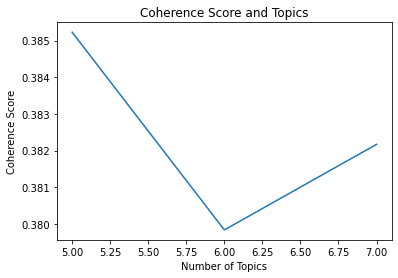

In [62]:
# Compute coherence score
number_of_topics = []
coherence_scores = []

for i in tqdm(range(5,8)):
    lda_model = models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           iterations = 50,
                                           num_topics = i)
    
    coherence_model_lda = CoherenceModel(model = lda_model, 
                                       texts = processed_cases, 
                                       dictionary = id2word, 
                                       coherence = 'c_v')
    
    coherence_score = coherence_model_lda.get_coherence()
    number_of_topics.append(i)
    coherence_scores.append(coherence_score)

# Create a dataframe of coherence score by number of topics 
topic_coherence = pd.DataFrame({'Number of Topics' : number_of_topics,
                                'Coherence Score' : coherence_scores})

# Print a line plot
sns.lineplot(data = topic_coherence, x = 'Number of Topics', y='Coherence Score')
plt.title('Coherence Score and Topics')

In [63]:
topic_coherence

,Number of Topics,Coherence Score
0,5,0.385226
1,6,0.379838
2,7,0.382171


In [65]:
# Model with the best number of topics
lda_model = models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 5, 
                                           random_state = 100,
                                           update_every = 1,
                                           chunksize = 10,
                                           passes = 10,
                                           alpha = 'symmetric',
                                           iterations = 350,
                                           per_word_topics = True)

In [66]:
lda_model.save('LDA_5_Topics_No_Unimportant')

In [67]:
lda_model = models.ldamodel.LdaModel.load('LDA_5_Topics_No_Unimportant')

In [68]:
lda_model.show_topics()

[(0,
  '0.038*"court" + 0.026*"state" + 0.026*"sentence" + 0.022*"united" + 0.020*"district" + 0.017*"cir" + 0.011*"defendant" + 0.010*"see" + 0.010*"government" + 0.009*"counsel"'),
 (1,
  '0.008*"would" + 0.006*"use" + 0.006*"act" + 0.006*"state" + 0.005*"law" + 0.005*"see" + 0.005*"price" + 0.005*"market" + 0.005*"one" + 0.005*"government"'),
 (2,
  '0.032*"court" + 0.016*"district" + 0.014*"claim" + 0.010*"cir" + 0.009*"state" + 0.009*"see" + 0.008*"appeal" + 0.007*"rule" + 0.007*"plaintiff" + 0.007*"judgment"'),
 (3,
  '0.024*"evidence" + 0.018*"officer" + 0.016*"jury" + 0.012*"testimony" + 0.012*"trial" + 0.010*"testify" + 0.009*"court" + 0.009*"find" + 0.009*"defendant" + 0.008*"reasonable"'),
 (4,
  '0.013*"evidence" + 0.011*"medical" + 0.010*"prisoner" + 0.010*"administrative" + 0.010*"health" + 0.010*"work" + 0.009*"program" + 0.009*"condition" + 0.008*"cir" + 0.008*"alj"')]

In [69]:
topic_words_dist = pd.DataFrame()
num_words = 100
for topic_id in range(lda_model.num_topics):
    topic_words = lda_model.get_topic_terms(topic_id, topn = num_words)
    props = []
    words = []
    for word_id, word_prob in topic_words:
        word = id2word[word_id]
        words.append(word)
        props.append(word_prob*100)
    topic_words_dist[f'Topic {topic_id} Words'] = words
    topic_words_dist[f'Topic {topic_id} Proportions'] = props

In [70]:
topic_words_dist

,Topic 0 Words,Topic 0 Proportions,Topic 1 Words,Topic 1 Proportions,Topic 2 Words,Topic 2 Proportions,Topic 3 Words,Topic 3 Proportions,Topic 4 Words,Topic 4 Proportions
0,court,3.774693,would,0.788544,court,3.229599,evidence,2.422599,evidence,1.311245
1,state,2.638878,use,0.640678,district,1.608922,officer,1.763800,medical,1.143611
2,sentence,2.567829,act,0.628865,claim,1.442042,jury,1.603008,prisoner,1.048860
3,united,2.238815,state,0.624400,cir,1.031056,testimony,1.230887,administrative,1.028478
4,district,1.958564,law,0.545651,state,0.943709,trial,1.166306,health,0.988748
...,...,...,...,...,...,...,...,...,...,...
95,ineffective,0.217372,interest,0.160277,employee,0.168273,place,0.184040,pain,0.215551
96,prosecution,0.211750,prosecutor,0.157021,proceeding,0.167878,williams,0.183758,doctor,0.212487
97,give,0.209834,might,0.156585,abuse,0.166647,johnson,0.183661,dyer,0.212079
98,pursuant,0.209449,intend,0.152459,show,0.165266,brown,0.181287,whether,0.209018


In [71]:
#Identification of the main topics per document

main_topic_keys = []
main_topic_percs = []
topic_keywords_list = []

for i, row_list in enumerate(lda_model[corpus]):
    topics = sorted(row_list[0], key = lambda x: (x[1]), reverse=True)
    main_topic_keys.append(topics[0][0])
    main_topic_percs.append(topics[0][1]*100)
    main_topic = lda_model.show_topic(topics[0][0])
    topic_keywords_list.append(", ".join([word for word, prop in main_topic]))
    
main_topic_df = pd.DataFrame()
main_topic_df['Main Topic'] = main_topic_keys
main_topic_df['Main Topic %'] = main_topic_percs
main_topic_df['Main Topic Keywords'] = topic_keywords_list

main_topic_df.head() 

,Main Topic,Main Topic %,Main Topic Keywords
0,1,35.572901,"would, use, act, state, law, see, price, marke..."
1,1,39.416069,"would, use, act, state, law, see, price, marke..."
2,2,43.797439,"court, district, claim, cir, state, see, appea..."
3,0,38.442931,"court, state, sentence, united, district, cir,..."
4,3,46.238589,"evidence, officer, jury, testimony, trial, tes..."


### 4 Topics

In [21]:
y_1 = [1 for i in range(pos_cases.shape[0])]
y_2 = [0 for i in range(neg_cases.shape[0])]
y = y_1 + y_2

main_topic_df['Label'] = y
main_topic_df.head()

,Main Topic,Main Topic %,Main Topic Keywords,Label
0,1,62.177110,"evidence, officer, jury, find, testimony, woul...",1
1,1,69.294286,"evidence, officer, jury, find, testimony, woul...",1
2,1,43.848127,"evidence, officer, jury, find, testimony, woul...",1
3,3,48.684666,"court, state, sentence, united, district, cir,...",1
4,1,75.696671,"evidence, officer, jury, find, testimony, woul...",1


In [22]:
perc_labels = []

for i in range(4):
    tot = main_topic_df[main_topic_df['Main Topic'] == i].shape[0]
    labels = main_topic_df.loc[main_topic_df['Main Topic'] == i, 'Label'].sum()
    perc_labels.append(labels*100/tot)

perc_labels

[5.538140020898641, 86.3299187566231, 38.045685279187815, 10.357518401682439]

### 6 Topics

In [30]:
y_1 = [1 for i in range(pos_cases.shape[0])]
y_2 = [0 for i in range(neg_cases.shape[0])]
y = y_1 + y_2

main_topic_df['Label'] = y
main_topic_df.head()

,Main Topic,Main Topic %,Main Topic Keywords,Label
0,1,58.022773,"officer, search, state, police, arrest, vehicl...",1
1,1,63.995951,"officer, search, state, police, arrest, vehicl...",1
2,1,37.680987,"officer, search, state, police, arrest, vehicl...",1
3,3,48.086408,"court, state, sentence, united, district, defe...",1
4,1,70.087612,"officer, search, state, police, arrest, vehicl...",1


In [31]:
perc_labels = []

for i in range(6):
    tot = main_topic_df[main_topic_df['Main Topic'] == i].shape[0]
    labels = main_topic_df.loc[main_topic_df['Main Topic'] == i, 'Label'].sum()
    perc_labels.append(labels*100/tot)

perc_labels

[59.129692832764505,
 91.5764705882353,
 28.544600938967136,
 16.174466151749204,
 7.733619763694952,
 48.36601307189542]

In [32]:
main_topic_df[main_topic_df['Main Topic'] == 1].shape[0]

2125

## 7 Topics No Court

In [28]:
y_1 = [1 for i in range(pos_cases.shape[0])]
y_2 = [0 for i in range(neg_cases.shape[0])]
y = y_1 + y_2

main_topic_df['Label'] = y
perc_labels = []

for i in range(7):
    tot = main_topic_df[main_topic_df['Main Topic'] == i].shape[0]
    labels = main_topic_df.loc[main_topic_df['Main Topic'] == i, 'Label'].sum()
    perc_labels.append(labels*100/tot)

perc_labels

[3.3333333333333335,
 20.136363636363637,
 41.56378600823045,
 13.777777777777779,
 41.221374045801525,
 93.9967105263158,
 95.45454545454545]

In [27]:
print(main_topic_df[main_topic_df['Main Topic'] == 5].shape[0])

1216

In [29]:
print(main_topic_df[main_topic_df['Main Topic'] == 6].shape[0])

352


In [36]:
#topic_words_dist.to_csv('7_Topics_Keywords.csv')

## 5 Topics Clean

In [72]:
y_1 = [1 for i in range(pos_cases.shape[0])]
y_2 = [0 for i in range(neg_cases.shape[0])]
y = y_1 + y_2

main_topic_df['Label'] = y
perc_labels = []

for i in range(5):
    tot = main_topic_df[main_topic_df['Main Topic'] == i].shape[0]
    labels = main_topic_df.loc[main_topic_df['Main Topic'] == i, 'Label'].sum()
    perc_labels.append(labels*100/tot)

perc_labels

[7.529948659440958,
 18.837675350701403,
 37.92760540970565,
 90.82321187584346,
 32.28346456692913]

In [73]:
topic_words_dist.to_csv('5_Topics_Clean_Keywords.csv')

# Topics Visualization 

# Graph 1

In [30]:
#TSNE 1

topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])
    
weights = pd.DataFrame(topic_weights).fillna(0).values
tsne_model = TSNE(n_components=2, verbose=1, init='pca')
tsne_lda = tsne_model.fit_transform(weights)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9630 samples in 0.058s...
[t-SNE] Computed neighbors for 9630 samples in 1.656s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9630
[t-SNE] Computed conditional probabilities for sample 2000 / 9630
[t-SNE] Computed conditional probabilities for sample 3000 / 9630
[t-SNE] Computed conditional probabilities for sample 4000 / 9630
[t-SNE] Computed conditional probabilities for sample 5000 / 9630
[t-SNE] Computed conditional probabilities for sample 6000 / 9630
[t-SNE] Computed conditional probabilities for sample 7000 / 9630
[t-SNE] Computed conditional probabilities for sample 8000 / 9630
[t-SNE] Computed conditional probabilities for sample 9000 / 9630
[t-SNE] Computed conditional probabilities for sample 9630 / 9630
[t-SNE] Mean sigma: 0.039053
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.811310
[t-SNE] KL divergence after 1000 iterations: 1.387170


In [31]:
output_notebook()
topic_num = np.argmax(weights, axis=1)
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(7), 
              plot_width=900, plot_height=500)

plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color = mycolors[topic_num])
show(plot)

Loading BokehJS ...

# Graph 2 

In [16]:
cases_2 = [' '.join(processed_cases[i]) for i in range(len(processed_cases))]
vectorizer = CountVectorizer()
word_matrix = vectorizer.fit_transform(cases_2)
word_matrix

<9630x88784 sparse matrix of type '<class 'numpy.int64'>'
	with 4813223 stored elements in Compressed Sparse Row format>

In [17]:
# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 

lda_model_2 = lda.LDA(n_topics = 4, n_iter = 350)
lda_topic_matrix = lda_model_2.fit_transform(word_matrix)
tsne_model = TSNE(n_components = 2, verbose = 0, init = 'pca')
tsne_result = tsne_model.fit_transform(lda_topic_matrix)
tsne_result.shape

INFO:lda:n_documents: 9630
INFO:lda:vocab_size: 88784
INFO:lda:n_words: 15142251
INFO:lda:n_topics: 4
INFO:lda:n_iter: 350
INFO:lda:<0> log likelihood: -142066498
INFO:lda:<10> log likelihood: -131690763
INFO:lda:<20> log likelihood: -126180882
INFO:lda:<30> log likelihood: -125446107
INFO:lda:<40> log likelihood: -124980849
INFO:lda:<50> log likelihood: -124698755
INFO:lda:<60> log likelihood: -124495514
INFO:lda:<70> log likelihood: -124338656
INFO:lda:<80> log likelihood: -124226699
INFO:lda:<90> log likelihood: -124139825
INFO:lda:<100> log likelihood: -124069158
INFO:lda:<110> log likelihood: -124002278
INFO:lda:<120> log likelihood: -123949885
INFO:lda:<130> log likelihood: -123905592
INFO:lda:<140> log likelihood: -123870422
INFO:lda:<150> log likelihood: -123843414
INFO:lda:<160> log likelihood: -123807312
INFO:lda:<170> log likelihood: -123788302
INFO:lda:<180> log likelihood: -123771440
INFO:lda:<190> log likelihood: -123740959
INFO:lda:<200> log likelihood: -123715345
INFO:l

(9630, 2)

In [18]:
output_notebook()
topic_num = np.argmax(lda_topic_matrix, axis=1)
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(4), 
              plot_width=900, plot_height=500)

plot.scatter(x=tsne_result[:,0], y=tsne_result[:,1], color = mycolors[topic_num])
show(plot)

Loading BokehJS ...

# Graph 3

On the left, we can see each topic represented as a bubble on the intertopic distance map (multidimensional scaling onto the x and y-axis) and if we click on a topic, visualization automatically adjusts to that specific topic. The distance between bubbles represents the semantic distance between topics, and in case bubbles are overlapping that means there are a lot of common words. In our case topics are well separated and do not overlap. In addition, the area of the topic bubbles represents coverage of each topic.
The visualization on the right side shows the top 30 most relevant words per topic the blue shaded bar represents the occurrence of the word in all reviews and the red bar represents the occurrence of the word within the selected topic. On top of it, you can see a slide to adjust the relevance metric λ (where 0 ≤ λ ≤ 1) and λ = 1 tunes the visualization for the words most likely to occur in each topic, and λ = 0 tunes for the words only specific for the selected topic.

In [18]:
# Visualization of the topics
'''
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, 
                                     corpus, 
                                     dictionary=lda_model.id2word)
vis
'''

'\npyLDAvis.enable_notebook()\n\nvis = pyLDAvis.gensim_models.prepare(lda_model, \n                                     corpus, \n                                     dictionary=lda_model.id2word)\nvis\n'